# Results Structure

Extract `results.rar` to `/results` folder.

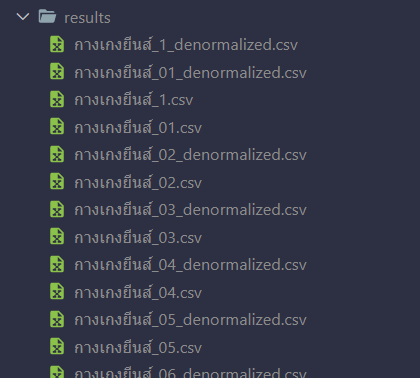

# Code

In [21]:
from os import listdir
from os.path import isfile, join
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
torch.cuda.is_available()

True

In [23]:
path = './results/'

In [24]:
files = [f for f in listdir(path) if isfile(join(path, f))]
files_denormalized = [f for f in files if "denormalized" in f]
files_normalized = [f for f in files if "denormalized" not in f]

In [25]:
mapping_file = './resources/Class_mapping.txt'
ctol = {}
ltoc = {}
with open(mapping_file) as f:
    for line in f:
        (key, val) = line.split()
        ctol[int(key)] = val
        ltoc[val] = int(key)

# Dataset

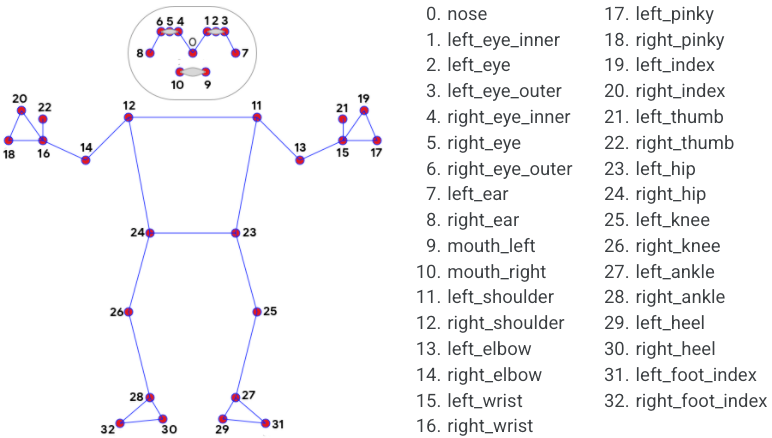
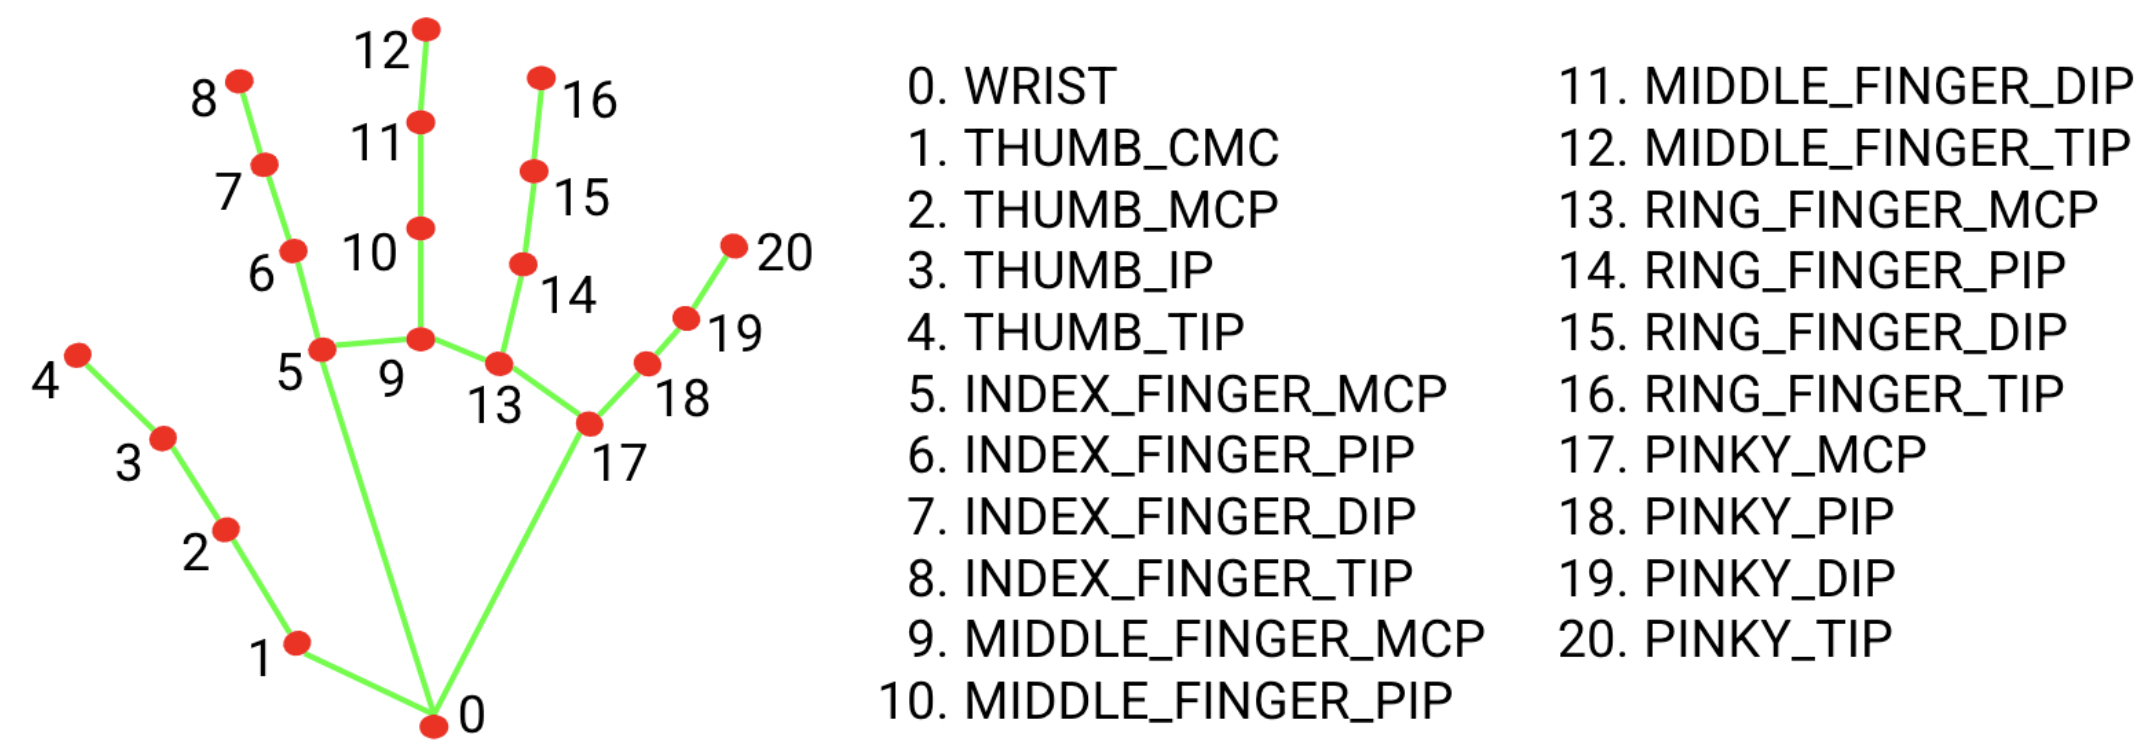

In [26]:
hand_index = np.array([0,1,4,5,8,9,12,13,16,17,20])
pose_index = np.array([0,11, 12, 13, 14, 15, 16, 23, 24])

In [27]:
col_name = []
hand_col_name = []
for pidx in pose_index:
    col_name.append('pose_' + str(pidx) + '_x')
    col_name.append('pose_' + str(pidx) + '_y')
for hidx in hand_index:
    col_name.append('left_hand_' + str(hidx) + '_x')
    col_name.append('left_hand_' + str(hidx) + '_y')
    hand_col_name.append('left_hand_' + str(hidx) + '_x')
    hand_col_name.append('left_hand_' + str(hidx) + '_y')
for hidx in hand_index:
    col_name.append('right_hand_' + str(hidx) + '_x')
    col_name.append('right_hand_' + str(hidx) + '_y')
    hand_col_name.append('right_hand_' + str(hidx) + '_x')
    hand_col_name.append('right_hand_' + str(hidx) + '_y')

## Define dataset

In [28]:
class LandmarksDataset(Dataset):
    """Hand Landmarks dataset."""

    def __init__(self, data_path, file_names, col_name, ltoc, preprocess_func, sample_func, device='cuda', transform=None, **kwargs):
        """
        Args:
            data_path (string): Path to the data folder.
            file_names (list): List of the file names.
            col_name (list): List of the column names. (e.g., [['pose_0', 'left_hand_0_x', 'right_hand_0_y'])
            ltoc (dict): Dictionary mapping label to class
            sample_func (function): Function to sample the data (e.g., to be 30 fps)
            transform (callable, optional): Optional transform to be applied
            **kwargs: Additional arguments for the sample_func
        """
        super(LandmarksDataset, self).__init__()
        self.data_path = data_path
        self.file_names = file_names
        self.col_name = col_name
        self.ltoc = ltoc
        self.device = device
        self.preprocess_func = preprocess_func
        self.sample_func = sample_func
        self.kwargs = kwargs
        self.transform = transform

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        df = pd.read_csv(self.data_path + file_name)
        df = df.drop(['index'], axis=1)
        df = df[self.col_name]
        
        
        # TODO: switch to sample before preprocess
        
        # processed_data = self.preprocess_func(df)
        # sample_data = self.sample_func(processed_data, **self.kwargs)
        
        sample_data = self.sample_func(df, **self.kwargs)
        sample_data = self.preprocess_func(sample_data)
        
        if isinstance(sample_data, pd.DataFrame):
            sample_data = sample_data.to_numpy()
        
        
        # get label from file name
        y = file_name.split('.')[0]
        y = y.split('_')[0]
        label = self.ltoc[y] - 1

        if self.transform:
            sample_data = self.transform(sample_data)
            
        sample_data = torch.from_numpy(sample_data).float().to(self.device)
        label = torch.tensor(label).long().to(self.device)

        return sample_data, label

In [29]:
def preprocess_data(df):
    data = df.copy()
    cols = df.columns
    x_col = [col for col in cols if 'x' in col]
    y_col = [col for col in cols if 'y' in col]
    
    data[x_col] = data[x_col].replace(0, 1.5)
    data[y_col] = data[y_col].replace(0, 1.5)
    
    # assume that we have pose_0
    mid_x = df['pose_0_x']
    mid_y = df['pose_0_y']
    shoulder_left_x = df['pose_11_x']
    shoulder_left_y = df['pose_11_y']
    shoulder_right_x = df['pose_12_x']
    shoulder_right_y = df['pose_12_y']
    
    shoulder_diff = np.sqrt((shoulder_left_x - shoulder_right_x)**2 + (shoulder_left_y - shoulder_right_y)**2)
    
    data[x_col] = data[x_col].apply(lambda x: x - mid_x)
    data[y_col] = data[y_col].apply(lambda x: x - mid_y)
    
    data = data.apply(lambda x: x / shoulder_diff)
    
    return data

In [30]:
def sample_data(df, len_sample=30):
    sample_idx = np.linspace(0, df.shape[0]-1, len_sample, dtype=int)
    return df.iloc[sample_idx].to_numpy()

In [31]:
def find_first_not(data, none_val):
    for i in range(len(data)):
        if data[i] != none_val:
            return i
    return 0

In [32]:
def sample_data_with_trim(df, col_name_not_none, len_sample=30):
    """
    trim the data of no movement
    Args:
        df (pd.DataFrame): Dataframe of the data
        col_name_not_none (list): List of column names, that has to have any value in the list > 0, the rest would be trimmed
        len_sample (int): Length of the sample
    """
    min_idx = min([find_first_not(df[col].to_numpy(), 0) for col in col_name_not_none])
    max_idx = len(df) - min([find_first_not(df[col].to_numpy()[::-1], 0) for col in col_name_not_none])
    
    trimmed_df = df.iloc[min_idx:max_idx]
    
    sample_idx = np.linspace(0, trimmed_df.shape[0]-1, len_sample, dtype=int)
        
    return trimmed_df.iloc[sample_idx]

In [33]:
X_train, X_test = train_test_split(files_normalized, test_size=0.2, random_state=42, stratify=[f.split('_')[0] for f in files_normalized])

# Model

In [34]:
from torch import nn

class SimpleLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, classes):
        super(SimpleLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_dim, hidden_dim, batch_first=True, num_layers=2, dropout=0.2)
        self.fc1 = nn.Linear(hidden_dim, classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x, _ = self.lstm1(x)
        x = x[:, -1, :]
        x = self.relu(x)
        x = self.fc1(x)
        out = self.softmax(x)
        return out

# `len_sample` search

In [3]:
len_sample_options = [i for i in range(25, 61, 5)]
len_sample_options

[25, 30, 35, 40, 45, 50, 55, 60]

In [35]:
from tqdm import tqdm

In [36]:
all_train_loss = []
all_train_acc = []
all_val_loss = []
all_val_acc = []
for len_sample in len_sample_options:
    print(f'len_sample: {len_sample}')
    train_dataset = LandmarksDataset(data_path=path, file_names=X_train, col_name=col_name, ltoc=ltoc, preprocess_func=preprocess_data, sample_func=sample_data_with_trim, len_sample=len_sample, col_name_not_none=hand_col_name)
    test_dataset = LandmarksDataset(data_path=path, file_names=X_test, col_name=col_name, ltoc=ltoc, preprocess_func=preprocess_data, sample_func=sample_data_with_trim, len_sample=len_sample, col_name_not_none=hand_col_name)
    train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True)
    
    model = SimpleLSTM(input_dim=len(col_name), hidden_dim=256, classes=len(ctol))
    model.to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)
    criterion = nn.CrossEntropyLoss()

    epochs = 100

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    max_val_acc = 0
    max_train_acc = 0
    for epoch in range(epochs):
        model.train()
        train_loss = []
        train_acc = []
        for batch in train_dataloader:
            optimizer.zero_grad()
            x, y = batch
            y_pred = model(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            train_acc.append((y_pred.argmax(dim=1) == y).sum().item() / len(y))
        scheduler.step(np.mean(train_loss))
        train_losses.append(np.mean(train_loss))
        train_accs.append(np.mean(train_acc))
        
        model.eval()
        val_loss = []
        val_acc = []
        for batch in test_dataloader:
            x, y = batch
            y_pred = model(x)
            loss = criterion(y_pred, y)
            val_loss.append(loss.item())
            val_acc.append((y_pred.argmax(dim=1) == y).sum().item() / len(y))
        val_losses.append(np.mean(val_loss))
        val_accs.append(np.mean(val_acc))
        
        torch.save(model.state_dict(), f'./model/model_sample_{len_sample}_epoch_{epoch+1}.pt')
        
        if epoch+1 % 20 == 0 or epoch==0:
            print(f'Epoch {epoch+1}/{epochs}: Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.4f}')
        # print(f'last epoch: Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.4f}')
    all_train_loss.append(train_losses)
    all_train_acc.append(train_accs)
    all_val_loss.append(val_losses)
    all_val_acc.append(val_accs)

len_sample: 25


KeyboardInterrupt: 

# w/o scheduler

In [39]:
all_train_loss = []
all_train_acc = []
all_val_loss = []
all_val_acc = []
for len_sample in len_sample_options:
    print(f'len_sample: {len_sample}')
    train_dataset = LandmarksDataset(data_path=path, file_names=X_train, col_name=col_name, ltoc=ltoc, preprocess_func=preprocess_data, sample_func=sample_data_with_trim, len_sample=len_sample, col_name_not_none=hand_col_name)
    test_dataset = LandmarksDataset(data_path=path, file_names=X_test, col_name=col_name, ltoc=ltoc, preprocess_func=preprocess_data, sample_func=sample_data_with_trim, len_sample=len_sample, col_name_not_none=hand_col_name)
    train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True)
    
    model = SimpleLSTM(input_dim=len(col_name), hidden_dim=256, classes=len(ctol))
    model.to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005)
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)
    criterion = nn.CrossEntropyLoss()

    epochs = 100

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    max_val_acc = 0
    max_train_acc = 0
    for epoch in tqdm(range(epochs)):
        model.train()
        train_loss = []
        train_acc = []
        for batch in train_dataloader:
            optimizer.zero_grad()
            x, y = batch
            y_pred = model(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            train_acc.append((y_pred.argmax(dim=1) == y).sum().item() / len(y))
        # scheduler.step(np.mean(train_loss))
        train_losses.append(np.mean(train_loss))
        train_accs.append(np.mean(train_acc))
        
        model.eval()
        val_loss = []
        val_acc = []
        for batch in test_dataloader:
            x, y = batch
            y_pred = model(x)
            loss = criterion(y_pred, y)
            val_loss.append(loss.item())
            val_acc.append((y_pred.argmax(dim=1) == y).sum().item() / len(y))
        val_losses.append(np.mean(val_loss))
        val_accs.append(np.mean(val_acc))
        
        torch.save(model.state_dict(), f'./model/model_sample_{len_sample}_epoch_{epoch+1}.pt')
        
        if epoch+1 % 20 == 0 or epoch==0:
            print(f'Epoch {epoch+1}/{epochs}: Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.4f}')
        # print(f'last epoch: Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.4f}')
    all_train_loss.append(train_losses)
    all_train_acc.append(train_accs)
    all_val_loss.append(val_losses)
    all_val_acc.append(val_accs)

len_sample: 25


  1%|          | 1/100 [00:09<15:30,  9.40s/it]

Epoch 1/100: Train Loss: 3.1710, Train Acc: 0.0597, Val Loss: 3.1513, Val Acc: 0.1000


100%|██████████| 100/100 [14:07<00:00,  8.48s/it]


len_sample: 30


  1%|          | 1/100 [00:09<15:08,  9.18s/it]

Epoch 1/100: Train Loss: 3.1712, Train Acc: 0.0708, Val Loss: 3.1328, Val Acc: 0.2000


100%|██████████| 100/100 [14:15<00:00,  8.55s/it]


len_sample: 35


  1%|          | 1/100 [00:08<14:37,  8.87s/it]

Epoch 1/100: Train Loss: 3.1729, Train Acc: 0.0583, Val Loss: 3.1526, Val Acc: 0.1500


100%|██████████| 100/100 [14:17<00:00,  8.58s/it]


len_sample: 40


  1%|          | 1/100 [00:08<14:10,  8.59s/it]

Epoch 1/100: Train Loss: 3.1726, Train Acc: 0.0708, Val Loss: 3.1501, Val Acc: 0.1333


100%|██████████| 100/100 [14:22<00:00,  8.63s/it]


len_sample: 45


  1%|          | 1/100 [00:08<14:34,  8.83s/it]

Epoch 1/100: Train Loss: 3.1711, Train Acc: 0.0625, Val Loss: 3.1428, Val Acc: 0.1167


100%|██████████| 100/100 [14:30<00:00,  8.70s/it]


len_sample: 50


  1%|          | 1/100 [00:08<14:34,  8.83s/it]

Epoch 1/100: Train Loss: 3.1717, Train Acc: 0.0625, Val Loss: 3.1446, Val Acc: 0.1500


100%|██████████| 100/100 [14:20<00:00,  8.60s/it]


len_sample: 55


  1%|          | 1/100 [00:08<14:41,  8.90s/it]

Epoch 1/100: Train Loss: 3.1731, Train Acc: 0.0500, Val Loss: 3.1530, Val Acc: 0.1333


100%|██████████| 100/100 [14:32<00:00,  8.73s/it]


len_sample: 60


  1%|          | 1/100 [00:09<15:20,  9.30s/it]

Epoch 1/100: Train Loss: 3.1734, Train Acc: 0.0500, Val Loss: 3.1550, Val Acc: 0.1500


100%|██████████| 100/100 [14:45<00:00,  8.85s/it]


In [40]:
for i in range(len(len_sample_options)):
    print(f'len_sample: {len_sample_options[i]} - max train acc: {max(all_train_acc[i]):.4f}, max val acc: {max(all_val_acc[i]):.4f}')

len_sample: 25 - max train acc: 0.8486, max val acc: 0.7167
len_sample: 30 - max train acc: 0.8292, max val acc: 0.7667
len_sample: 35 - max train acc: 0.8111, max val acc: 0.7667
len_sample: 40 - max train acc: 0.8569, max val acc: 0.7333
len_sample: 45 - max train acc: 0.8083, max val acc: 0.7000
len_sample: 50 - max train acc: 0.7139, max val acc: 0.6667
len_sample: 55 - max train acc: 0.7208, max val acc: 0.6667
len_sample: 60 - max train acc: 0.6958, max val acc: 0.6667


Text(0, 0.5, 'train loss')

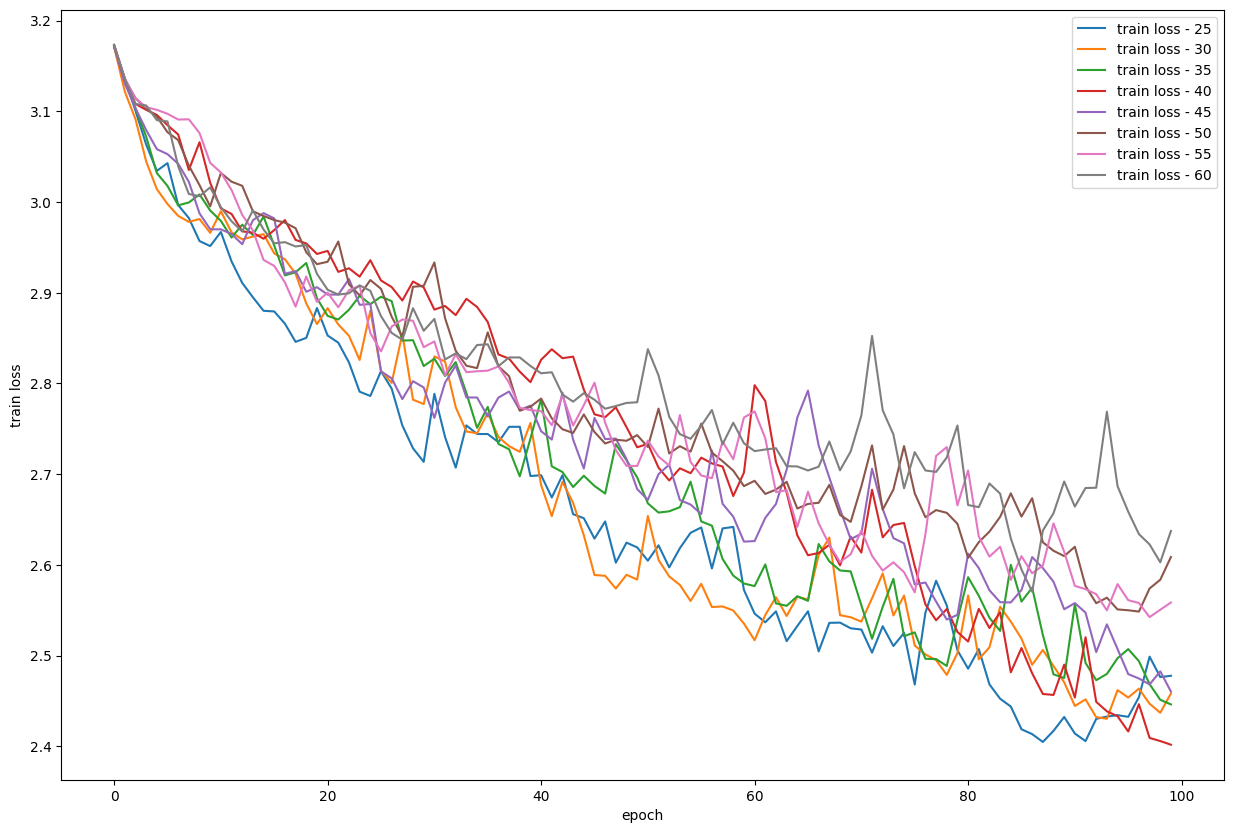

In [42]:
from matplotlib import pyplot as plt


plt.figure(figsize=(15, 10))
for i in range(len(len_sample_options)):
    plt.plot(all_train_loss[i], label=f'train loss - {len_sample_options[i]}')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('train loss')

Text(0, 0.5, 'val loss')

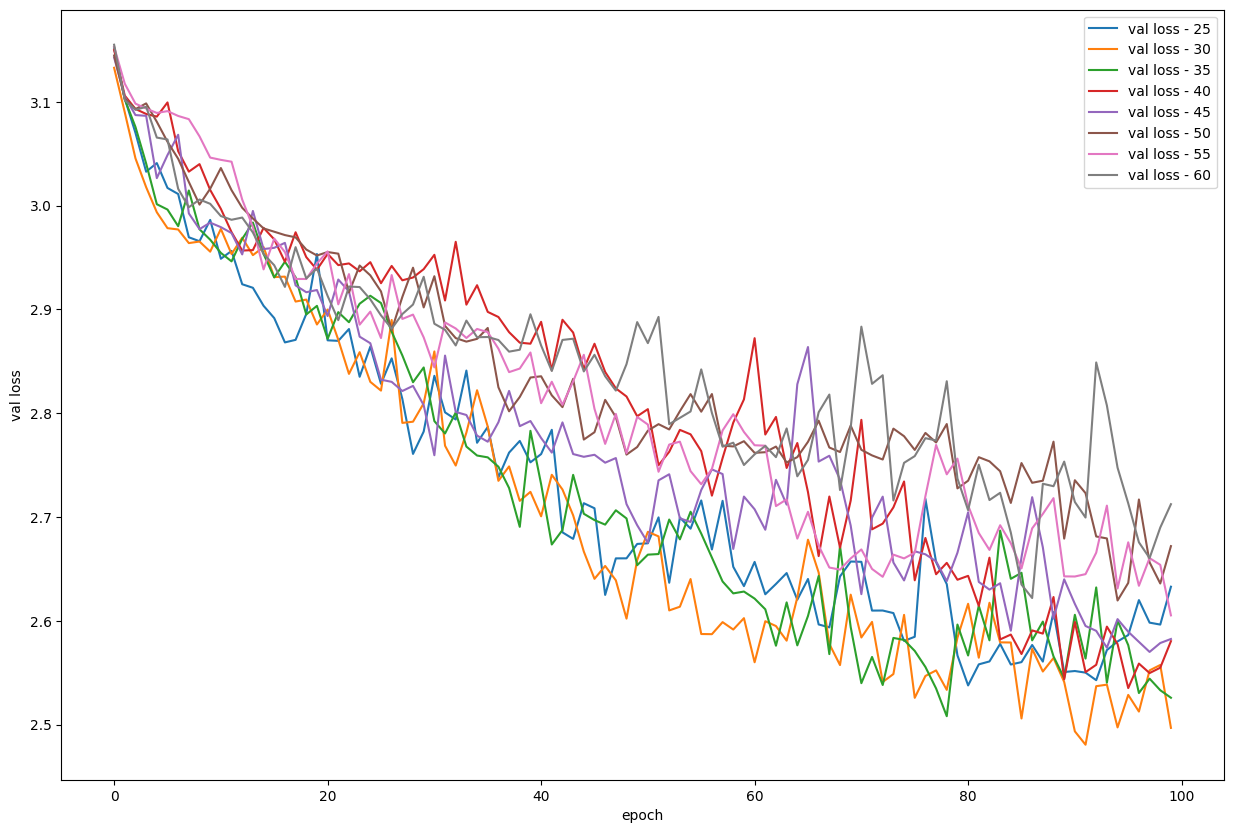

In [44]:
plt.figure(figsize=(15, 10))
for i in range(len(len_sample_options)):
    plt.plot(all_val_loss[i], label=f'val loss - {len_sample_options[i]}')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('val loss')

Text(0, 0.5, 'train acc')

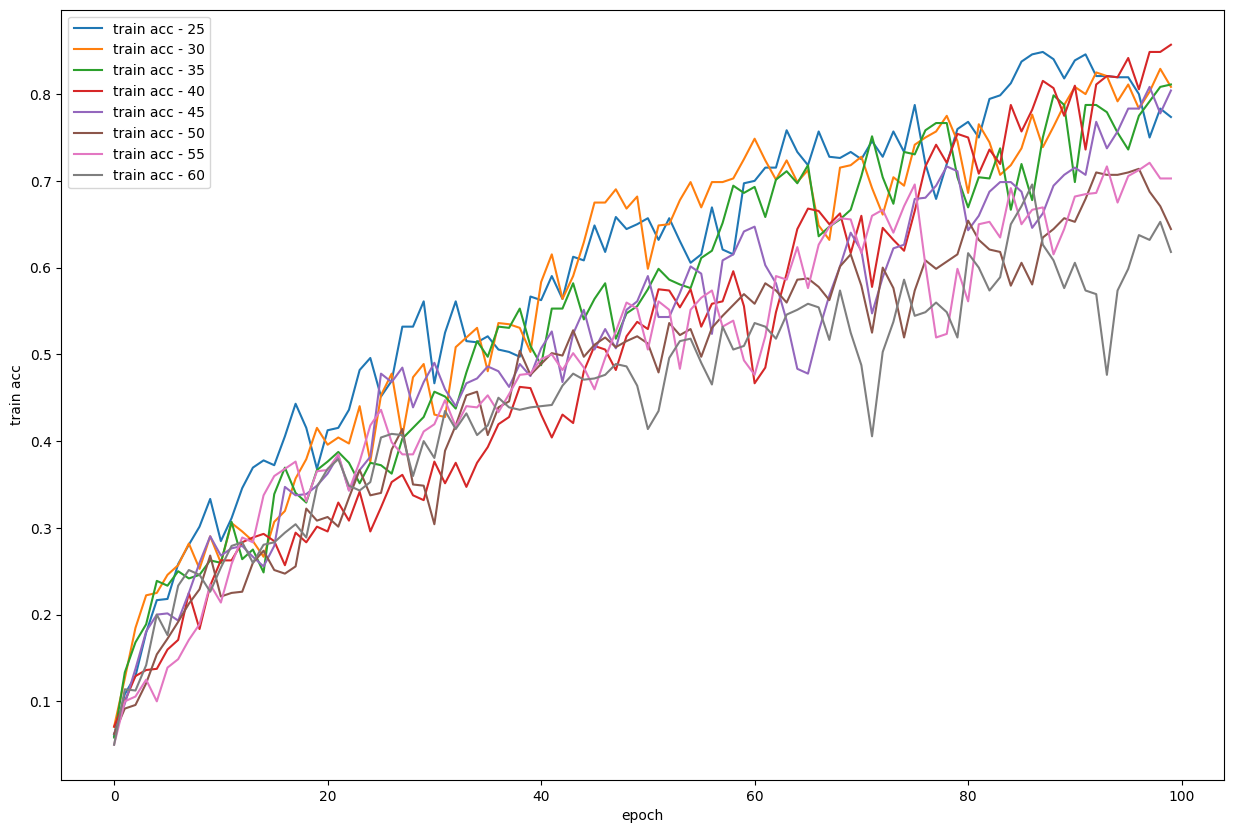

In [45]:
plt.figure(figsize=(15, 10))
for i in range(len(len_sample_options)):
    plt.plot(all_train_acc[i], label=f'train acc - {len_sample_options[i]}')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('train acc')

Text(0, 0.5, 'val acc')

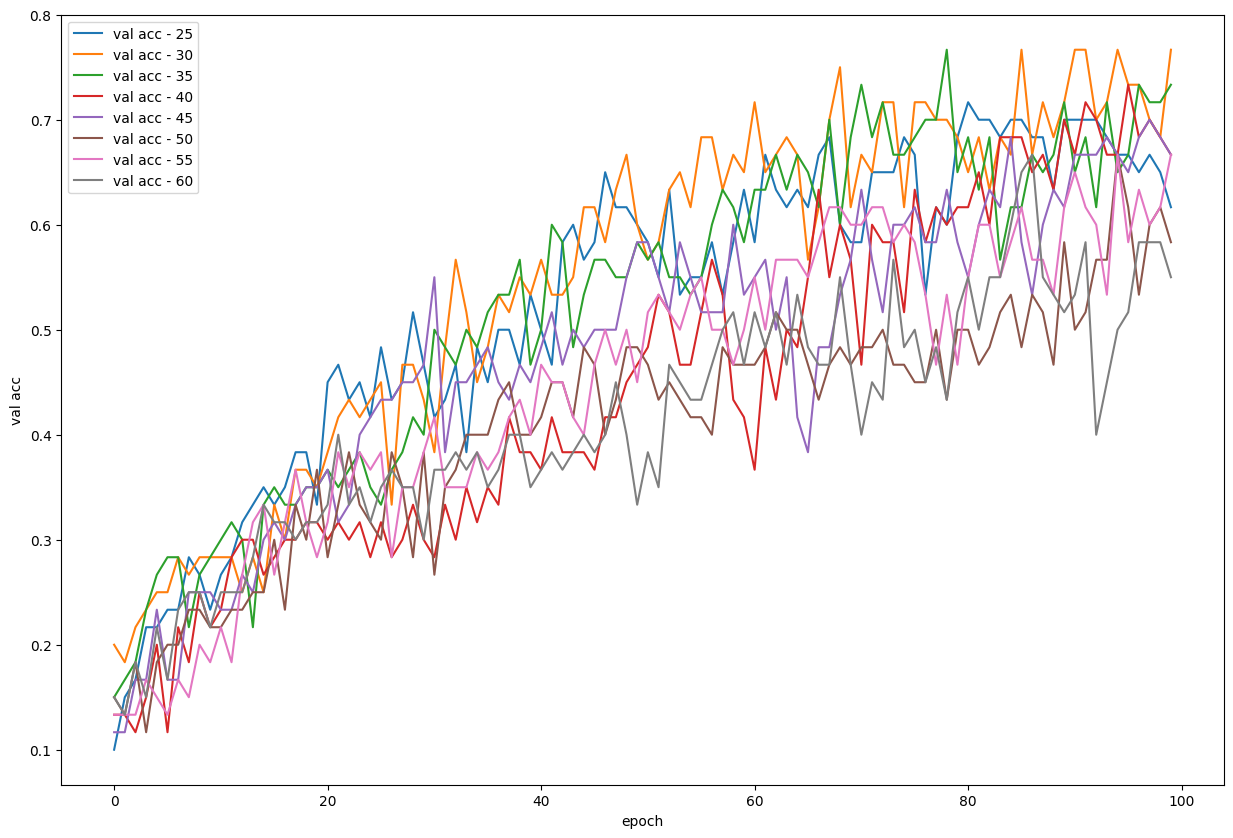

In [46]:
plt.figure(figsize=(15, 10))
for i in range(len(len_sample_options)):
    plt.plot(all_val_acc[i], label=f'val acc - {len_sample_options[i]}')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('val acc')